In [22]:
import json
import csv
import pandas as pd
import numpy as np
import scipy as sci
import keras
from keras.models import Sequential
from keras import regularizers
from keras.layers.core import Dense, Activation
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import io
import requests
import tensorflow as tf
from scipy import sparse
from sklearn.model_selection import train_test_split
import sklearn.feature_extraction.text as sk_text
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import shutil
import os

# Necessary Functions

In [23]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Data Processing 

In [60]:
network_df= pd.read_csv('network_intrusion_data.csv', delimiter =",")

In [61]:
#Add column headers to the data in the dataframe
network_df.columns = [
'duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'outcome'
]

In [62]:
network_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [63]:
network_df.shape

(494020, 42)

In [64]:
network_df.drop_duplicates(keep='first', inplace=True)

In [65]:
network_df.shape

(145585, 42)

In [66]:
network_df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [67]:
#Normalize numeric features

def normalize_numeric_minmax(df, name):
    if(df[name].max() > 0):
        df[name] = ((df[name] - df[name].min()) / (df[name].max() - df[name].min())).astype(np.float32)
    else:
        df[name] = df[name].astype(np.float32)

normalize_numeric_minmax(network_df,"duration")
encode_text_dummy(network_df,"protocol_type") 
encode_text_dummy(network_df,"service") 
encode_text_dummy(network_df,"flag")
normalize_numeric_minmax(network_df,"src_bytes") 
normalize_numeric_minmax(network_df,"dst_bytes")
encode_text_dummy(network_df,"land")
normalize_numeric_minmax(network_df,"wrong_fragment") 
normalize_numeric_minmax(network_df,"urgent")
normalize_numeric_minmax(network_df,"hot")
normalize_numeric_minmax(network_df,"num_failed_logins")
encode_text_dummy(network_df,"logged_in")
normalize_numeric_minmax(network_df,"num_compromised")
normalize_numeric_minmax(network_df,"root_shell")
normalize_numeric_minmax(network_df,"su_attempted")
normalize_numeric_minmax(network_df,"num_root")
normalize_numeric_minmax(network_df,"num_file_creations")
normalize_numeric_minmax(network_df,"num_shells")
normalize_numeric_minmax(network_df,"num_access_files")
normalize_numeric_minmax(network_df,"num_outbound_cmds")
encode_text_dummy(network_df,"is_host_login")
encode_text_dummy(network_df,"is_guest_login")
normalize_numeric_minmax(network_df,"count") 
normalize_numeric_minmax(network_df,"srv_count") 
normalize_numeric_minmax(network_df,"serror_rate") 
normalize_numeric_minmax(network_df,"srv_serror_rate") 
normalize_numeric_minmax(network_df,"rerror_rate") 
normalize_numeric_minmax(network_df,"srv_rerror_rate") 
normalize_numeric_minmax(network_df,"same_srv_rate") 
normalize_numeric_minmax(network_df,"diff_srv_rate") 
normalize_numeric_minmax(network_df,"srv_diff_host_rate") 
normalize_numeric_minmax(network_df,"dst_host_count") 
normalize_numeric_minmax(network_df,"dst_host_srv_count") 
normalize_numeric_minmax(network_df,"dst_host_same_srv_rate") 
normalize_numeric_minmax(network_df,"dst_host_diff_srv_rate") 
normalize_numeric_minmax(network_df,"dst_host_same_src_port_rate") 
normalize_numeric_minmax(network_df,"dst_host_srv_diff_host_rate") 
normalize_numeric_minmax(network_df,"dst_host_serror_rate") 
normalize_numeric_minmax(network_df,"dst_host_srv_serror_rate") 
normalize_numeric_minmax(network_df,"dst_host_rerror_rate") 
normalize_numeric_minmax(network_df,"dst_host_srv_rerror_rate") 

In [68]:
network_df.dtypes

duration                       float32
src_bytes                      float32
dst_bytes                      float32
wrong_fragment                 float32
urgent                         float32
hot                            float32
num_failed_logins              float32
num_compromised                float32
root_shell                     float32
su_attempted                   float32
num_root                       float32
num_file_creations             float32
num_shells                     float32
num_access_files               float32
num_outbound_cmds              float32
count                          float32
srv_count                      float32
serror_rate                    float32
srv_serror_rate                float32
rerror_rate                    float32
srv_rerror_rate                float32
same_srv_rate                  float32
diff_srv_rate                  float32
srv_diff_host_rate             float32
dst_host_count                 float32
dst_host_srv_count       

In [69]:
# create a function called encodeLabelBinarizer

encodeLabelBinary = lambda x: 0 if x == 'normal.' else 1

In [70]:
network_df['outcome'] = network_df['outcome'].apply(encodeLabelBinary)

In [71]:
network_df.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,0.0,3.446905e-07,0.000094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,1,1,1,0
1,0.0,3.389216e-07,0.000259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,1,1,1,0
2,0.0,3.158461e-07,0.000259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,1,1,1,0
3,0.0,3.129617e-07,0.000394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,1,1,1,0
4,0.0,3.129617e-07,0.000394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,1,1,1,0


In [72]:
x,y=to_xy(network_df,"outcome")

In [73]:
x.shape

(145585, 121)

In [74]:
y.shape

(145585, 2)

# Neural Network

In [75]:
x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(x,y, test_size=0.2, random_state=42)

In [76]:
model = Sequential()
model.add(Dense(10, input_dim=x_train_nn.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x_train_nn,y_train_nn,validation_data=(x_test_nn,y_test_nn),callbacks=[monitor],verbose=2,epochs=1000)

Train on 116468 samples, validate on 29117 samples
Epoch 1/1000
 - 4s - loss: 0.0438 - val_loss: 0.0146
Epoch 2/1000
 - 4s - loss: 0.0121 - val_loss: 0.0097
Epoch 3/1000
 - 4s - loss: 0.0093 - val_loss: 0.0068
Epoch 4/1000
 - 4s - loss: 0.0085 - val_loss: 0.0080
Epoch 5/1000
 - 4s - loss: 0.0078 - val_loss: 0.0096
Epoch 6/1000
 - 4s - loss: 0.0076 - val_loss: 0.0072
Epoch 7/1000
 - 4s - loss: 0.0070 - val_loss: 0.0077
Epoch 8/1000
 - 4s - loss: 0.0069 - val_loss: 0.0059
Epoch 00008: early stopping


In [77]:
# Measure accuracy
pred_nn = model.predict(x_test_nn)
pred_nn = np.argmax(pred_nn,axis=1)
y_eval = np.argmax(y_test_nn,axis=1)
score_nn = accuracy_score(y_eval, pred_nn)
print("Validation score: {}".format(score_nn))

Validation score: 0.9985231995054435


# CNN

In [78]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [79]:
x_train.shape

(116468, 121)

In [80]:
y_train.shape

(116468, 2)

In [81]:
x_test.shape

(29117, 121)

In [82]:
y_test.shape

(29117, 2)

In [83]:
# we now reshape the x_train and x_test to image form used in CNN 2D
x_train = x_train.reshape(x_train.shape[0], 1, 121, 1)
x_test = x_test.reshape(x_test.shape[0], 1, 121, 1)

In [84]:
x_train.shape

(116468, 1, 121, 1)

In [85]:
x_test.shape

(29117, 1, 121, 1)

In [86]:
x_train[0:5]

array([[[[0.0000000e+00],
         [2.9853948e-07],
         [1.4954996e-04],
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         [2.7397260e-02],
         [3.1311154e-02],
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         [1.0000000e+00],
         [0.0000000e+00],
         [1.2000000e-01],
         [6.1176473e-01],
         [1.0000000e+00],
         [1.0000000e+00],
         [0.0000000e+00],
         [9.9999998e-03],
         [2.0000000e-02],
         [9.9999998e-03],
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         [1.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         [0.

In [222]:
# finally the much avaited CNN 2D

cnn = Sequential()

# Conv2D layer 1
cnn.add(Conv2D(41, kernel_size=(1, 3), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=(1,121,1)))




In [223]:
cnn.add(Conv2D(64, (1, 3), activation='relu'))

cnn.add(MaxPooling2D(pool_size=(1, 2), strides=None))

cnn.add(Dropout(0.25))

cnn.add(Flatten())

In [224]:

cnn.add(Dense(128, activation='relu'))

cnn.add(Dropout(0.5))

cnn.add(Dense(2, activation='softmax'))

In [225]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 1, 119, 41)        164       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 117, 64)        7936      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 58, 64)         0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 1, 58, 64)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 3712)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               475264    
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
__________

In [108]:
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [109]:
cnn.fit(x_train, y_train,     
          batch_size=128,
          epochs=10,
          verbose=2,
          validation_data=(x_test, y_test))

Train on 116468 samples, validate on 29117 samples
Epoch 1/10
 - 31s - loss: 0.0401 - acc: 0.9881 - val_loss: 0.0107 - val_acc: 0.9964
Epoch 2/10
 - 31s - loss: 0.0144 - acc: 0.9956 - val_loss: 0.0082 - val_acc: 0.9976
Epoch 3/10
 - 30s - loss: 0.0114 - acc: 0.9966 - val_loss: 0.0071 - val_acc: 0.9980
Epoch 4/10
 - 33s - loss: 0.0102 - acc: 0.9971 - val_loss: 0.0061 - val_acc: 0.9979
Epoch 5/10
 - 35s - loss: 0.0088 - acc: 0.9973 - val_loss: 0.0061 - val_acc: 0.9979
Epoch 6/10
 - 31s - loss: 0.0086 - acc: 0.9975 - val_loss: 0.0054 - val_acc: 0.9984
Epoch 7/10
 - 32s - loss: 0.0076 - acc: 0.9978 - val_loss: 0.0045 - val_acc: 0.9986
Epoch 8/10
 - 30s - loss: 0.0074 - acc: 0.9978 - val_loss: 0.0049 - val_acc: 0.9985
Epoch 9/10
 - 31s - loss: 0.0070 - acc: 0.9979 - val_loss: 0.0040 - val_acc: 0.9987
Epoch 10/10
 - 30s - loss: 0.0071 - acc: 0.9979 - val_loss: 0.0050 - val_acc: 0.9984


In [110]:
# Evaluate Accuracy in Keras
score = cnn.evaluate(x_test, y_test, verbose=0)
score

[0.00503477076572647, 0.9984201669128001]

In [111]:
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

Test loss: 0.00503477076572647
Test accuracy: 0.9984201669128001


In [112]:
pred = cnn.predict(x_test)
pred = np.argmax(pred,axis=1)

In [113]:
pred

array([0, 1, 0, ..., 1, 1, 1])

In [114]:

y_true = np.argmax(y_test,axis=1)
y_true

array([0, 1, 0, ..., 1, 1, 1])

In [115]:
cm_cnn = confusion_matrix(y_true, pred)
print(cm_cnn)

[[17573    16]
 [   30 11498]]


In [116]:
outcome = encode_text_index(network_df,'outcome')

Plotting confusion matrix


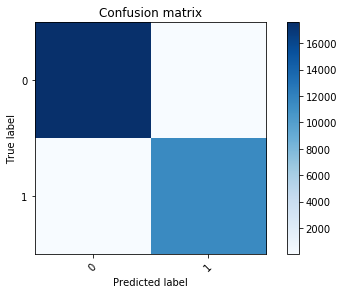

In [117]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_cnn, outcome)
plt.show()

In [118]:
print(classification_report(y_true, pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17589
          1       1.00      1.00      1.00     11528

avg / total       1.00      1.00      1.00     29117



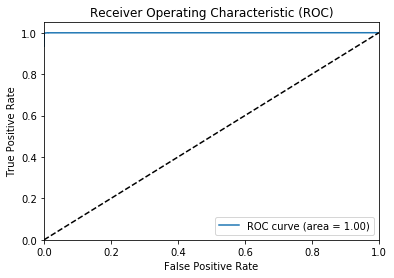

In [119]:
pred = cnn.predict(x_test)
pred = pred[:,1]
plot_roc(pred,y_true)

# CNN Architecture expriment

In [233]:
# finally the much avaited CNN 2D

cnn_exp = Sequential()

# Conv2D layer 1
cnn_exp.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=(1,121,1)))




In [234]:
cnn_exp.add(Conv2D(64, (1, 3), activation='relu'))

cnn_exp.add(MaxPooling2D(pool_size=(1, 2), strides=None))

cnn_exp.add(Conv2D(128, (1, 3), activation='relu'))

cnn_exp.add(Conv2D(128, (1, 3), activation='relu'))

cnn_exp.add(Conv2D(128, (1, 3), activation='relu'))

cnn_exp.add(MaxPooling2D(pool_size=(1, 2), strides=None))

cnn_exp.add(Conv2D(256, (1, 3), activation='relu'))

cnn_exp.add(Conv2D(256, (1, 3), activation='relu'))

cnn_exp.add(Conv2D(256, (1, 3), activation='relu'))

cnn_exp.add(MaxPooling2D(pool_size=(1, 2), strides=None))

cnn_exp.add(Flatten())

In [235]:

cnn_exp.add(Dense(100, activation='relu'))

cnn_exp.add(Dropout(0.5))

cnn_exp.add(Dense(20, activation='relu'))

cnn_exp.add(Dense(2, activation='softmax'))

In [236]:
cnn_exp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 1, 119, 64)        256       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 1, 117, 64)        12352     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 1, 58, 64)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 1, 56, 128)        24704     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 1, 54, 128)        49280     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 1, 52, 128)        49280     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 1, 26, 128)        0         
__________

In [237]:
cnn_exp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
cnn_exp.fit(x_train, y_train,     
          batch_size=128,
          epochs=10,
          verbose=2,
          validation_data=(x_test, y_test))

Train on 116468 samples, validate on 29117 samples
Epoch 1/10


In [ ]:
# Evaluate Accuracy in Keras
score = cnn.evaluate(x_test, y_test, verbose=0)
score

In [ ]:
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

In [ ]:
pred = cnn.predict(x_test)
pred = np.argmax(pred,axis=1)

In [ ]:
pred

In [ ]:

y_true = np.argmax(y_test,axis=1)
y_true

In [ ]:
cm_cnn = confusion_matrix(y_true, pred)
print(cm_cnn)

In [ ]:
outcome = encode_text_index(network_df,'outcome')

In [ ]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_cnn, outcome)
plt.show()

In [ ]:
print(classification_report(y_true, pred))

In [ ]:
pred = cnn.predict(x_test)
pred = pred[:,1]
plot_roc(pred,y_true)

# CNN with all attacks - Multilabel Classifier

In [186]:
network_cnn_df= pd.read_csv('network_intrusion_data.csv', delimiter =",")

In [187]:
network_cnn_df.columns = [
'duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'outcome'
]

In [188]:
normalize_numeric_minmax(network_cnn_df,"duration")
encode_text_dummy(network_cnn_df,"protocol_type") 
encode_text_dummy(network_cnn_df,"service") 
encode_text_dummy(network_cnn_df,"flag")
normalize_numeric_minmax(network_cnn_df,"src_bytes") 
normalize_numeric_minmax(network_cnn_df,"dst_bytes")
encode_text_dummy(network_cnn_df,"land")
normalize_numeric_minmax(network_cnn_df,"wrong_fragment") 
normalize_numeric_minmax(network_cnn_df,"urgent")
normalize_numeric_minmax(network_cnn_df,"hot")
normalize_numeric_minmax(network_cnn_df,"num_failed_logins")
encode_text_dummy(network_cnn_df,"logged_in")
normalize_numeric_minmax(network_cnn_df,"num_compromised")
normalize_numeric_minmax(network_cnn_df,"root_shell")
normalize_numeric_minmax(network_cnn_df,"su_attempted")
normalize_numeric_minmax(network_cnn_df,"num_root")
normalize_numeric_minmax(network_cnn_df,"num_file_creations")
normalize_numeric_minmax(network_cnn_df,"num_shells")
normalize_numeric_minmax(network_cnn_df,"num_access_files")
normalize_numeric_minmax(network_cnn_df,"num_outbound_cmds")
encode_text_dummy(network_cnn_df,"is_host_login")
encode_text_dummy(network_cnn_df,"is_guest_login")
normalize_numeric_minmax(network_cnn_df,"count") 
normalize_numeric_minmax(network_cnn_df,"srv_count") 
normalize_numeric_minmax(network_cnn_df,"serror_rate") 
normalize_numeric_minmax(network_cnn_df,"srv_serror_rate") 
normalize_numeric_minmax(network_cnn_df,"rerror_rate") 
normalize_numeric_minmax(network_cnn_df,"srv_rerror_rate") 
normalize_numeric_minmax(network_cnn_df,"same_srv_rate") 
normalize_numeric_minmax(network_cnn_df,"diff_srv_rate") 
normalize_numeric_minmax(network_cnn_df,"srv_diff_host_rate") 
normalize_numeric_minmax(network_cnn_df,"dst_host_count") 
normalize_numeric_minmax(network_cnn_df,"dst_host_srv_count") 
normalize_numeric_minmax(network_cnn_df,"dst_host_same_srv_rate") 
normalize_numeric_minmax(network_cnn_df,"dst_host_diff_srv_rate") 
normalize_numeric_minmax(network_cnn_df,"dst_host_same_src_port_rate") 
normalize_numeric_minmax(network_cnn_df,"dst_host_srv_diff_host_rate") 
normalize_numeric_minmax(network_cnn_df,"dst_host_serror_rate") 
normalize_numeric_minmax(network_cnn_df,"dst_host_srv_serror_rate") 
normalize_numeric_minmax(network_cnn_df,"dst_host_rerror_rate") 
normalize_numeric_minmax(network_cnn_df,"dst_host_srv_rerror_rate") 

In [189]:
network_cnn_df.drop_duplicates(keep='first', inplace=True)

In [190]:
outcome_all = encode_text_index(network_cnn_df, 'outcome')

In [191]:
x_all,y_all = to_xy(network_cnn_df,'outcome')

In [192]:
x_all.shape

(145585, 121)

In [193]:
y_all.shape

(145585, 23)

In [194]:
x_all = x_all.reshape(x_all.shape[0], 1, 121, 1)

In [195]:
x_all.shape

(145585, 1, 121, 1)

In [196]:
x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(x_all,y_all, test_size=0.2, random_state=42)

In [197]:
x_train_all.shape

(116468, 1, 121, 1)

In [198]:
# finally the much avaited CNN 2D

cnn_all = Sequential()

# Conv2D layer 1
cnn_all.add(Conv2D(41, kernel_size=(1, 3), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=(1,121,1)))




In [199]:
cnn_all.add(Conv2D(64, (1, 3), activation='relu'))

cnn_all.add(MaxPooling2D(pool_size=(1, 2), strides=None))

cnn_all.add(Dropout(0.25))

cnn_all.add(Flatten())

In [200]:
cnn_all.add(Dense(128, activation='relu'))

cnn_all.add(Dropout(0.5))

cnn_all.add(Dense(23, activation='softmax'))

In [201]:
cnn_all.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 1, 119, 41)        164       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 117, 64)        7936      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 58, 64)         0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 1, 58, 64)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3712)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               475264    
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
__________

In [202]:
cnn_all.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [203]:
cnn_all.fit(x_train_all, y_train_all,     
          batch_size=128,
          epochs=10,
          verbose=2,
          validation_data=(x_test_all, y_test_all))

Train on 116468 samples, validate on 29117 samples
Epoch 1/10
 - 24s - loss: 0.0933 - acc: 0.9810 - val_loss: 0.0184 - val_acc: 0.9953
Epoch 2/10
 - 22s - loss: 0.0235 - acc: 0.9939 - val_loss: 0.0142 - val_acc: 0.9966
Epoch 3/10
 - 22s - loss: 0.0186 - acc: 0.9952 - val_loss: 0.0114 - val_acc: 0.9970
Epoch 4/10
 - 23s - loss: 0.0163 - acc: 0.9960 - val_loss: 0.0100 - val_acc: 0.9976
Epoch 5/10
 - 22s - loss: 0.0144 - acc: 0.9963 - val_loss: 0.0102 - val_acc: 0.9981
Epoch 6/10
 - 22s - loss: 0.0136 - acc: 0.9967 - val_loss: 0.0085 - val_acc: 0.9980
Epoch 7/10
 - 22s - loss: 0.0118 - acc: 0.9970 - val_loss: 0.0089 - val_acc: 0.9978
Epoch 8/10
 - 22s - loss: 0.0115 - acc: 0.9971 - val_loss: 0.0084 - val_acc: 0.9980
Epoch 9/10
 - 22s - loss: 0.0106 - acc: 0.9972 - val_loss: 0.0075 - val_acc: 0.9982
Epoch 10/10
 - 23s - loss: 0.0103 - acc: 0.9974 - val_loss: 0.0073 - val_acc: 0.9981


In [204]:
# Evaluate Accuracy in Keras
score = cnn_all.evaluate(x_test_all, y_test_all, verbose=0)
score

[0.007278166649342729, 0.9980767249373218]

In [205]:
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

Test loss: 0.007278166649342729
Test accuracy: 0.9980767249373218


In [206]:
pred_all = cnn_all.predict(x_test)
pred_all = np.argmax(pred_all,axis=1)

In [207]:
pred_all

array([11, 17, 11, ..., 18,  9,  9])

In [208]:

y_true_all = np.argmax(y_test_all,axis=1)
y_true_all

array([11, 17, 11, ..., 18,  9,  9])

In [209]:
cm_cnn_all = confusion_matrix(y_true_all, pred_all)
print(cm_cnn_all)

[[  190     0     0     0     0     0     0     0     0     0     1     0
      0     0     0     0     0     0     0]
 [    0     3     0     0     0     0     0     0     0     0     2     0
      0     0     0     0     0     1     0]
 [    0     0     0     0     0     1     0     0     0     0     3     0
      0     0     0     0     0     1     0]
 [    0     0     0    10     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     1     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     0   132     0     0     0     2     3     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     2     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     2     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     

In [210]:
#outcome_all = encode_text_index(network_cnn_df,'outcome')

Plotting confusion matrix


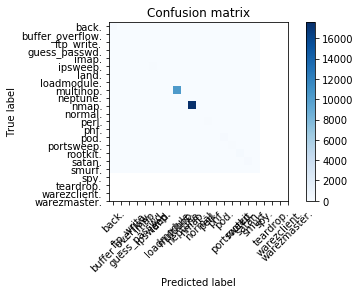

In [211]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_cnn_all, outcome_all)
plt.show()

In [212]:
print(classification_report(y_true_all, pred_all))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       191
          1       1.00      0.50      0.67         6
          2       0.00      0.00      0.00         5
          3       1.00      1.00      1.00        10
          4       1.00      1.00      1.00         1
          5       0.95      0.96      0.96       137
          6       1.00      1.00      1.00         2
          8       0.00      0.00      0.00         2
          9       1.00      1.00      1.00     10357
         10       0.93      0.71      0.81        38
         11       1.00      1.00      1.00     17589
         14       1.00      1.00      1.00        34
         15       1.00      0.98      0.99        92
         16       0.00      0.00      0.00         1
         17       0.98      0.97      0.98       158
         18       1.00      0.98      0.99       132
         20       1.00      1.00      1.00       208
         21       0.93      0.95      0.94   

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Feature Analysis

In [213]:
# Feature Importance
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

extraTreeClassifier = ExtraTreesClassifier()
extraTreeClassifier.fit(network_df, network_df['outcome'])

# display the relative importance of each attribute

print(extraTreeClassifier.feature_importances_)

[1.98178841e-04 4.18715840e-03 2.91162608e-04 4.56433795e-03
 1.11904767e-05 8.70198724e-04 2.39209960e-04 7.11047838e-04
 7.67538086e-05 0.00000000e+00 4.94430443e-06 3.08590702e-06
 2.82330864e-06 7.66525708e-06 0.00000000e+00 1.89712474e-02
 1.87474600e-03 6.85213923e-02 7.20432476e-02 6.46968297e-04
 2.10837929e-03 1.04491458e-02 7.17270851e-03 3.78261084e-03
 1.33095354e-03 1.99504969e-02 1.42499144e-01 1.23118890e-02
 7.00489521e-03 1.39780038e-02 1.40280831e-03 6.31176763e-02
 8.06086664e-03 1.08424917e-02 2.10018298e-01 2.46037297e-03
 1.16984867e-02 2.49823599e-03 3.35815969e-05 0.00000000e+00
 0.00000000e+00 2.71512129e-05 0.00000000e+00 5.96081221e-06
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 8.30550868e-04 1.30227215e-12 1.95067877e-04
 6.96677823e-04 0.00000000e+00 0.00000000e+00 4.70151960e-04
 8.70548464e-06 1.47816021e-03 2.74948291e-06 9.37918945e-09
 2.79356600e-04 0.00000000e+00 8.46858556e-06 0.00000000e+00
 0.00000000e+00 0.000000

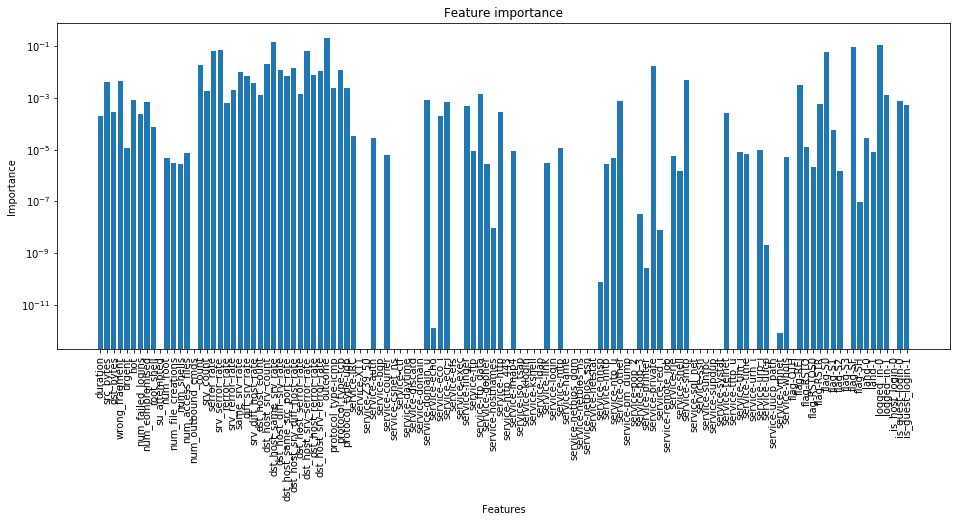

In [214]:
feature_importance = extraTreeClassifier.feature_importances_
plt.figure(figsize=(16, 6))
plt.yscale('log', nonposy='clip')
plt.bar(range(len(feature_importance)), feature_importance, align='center')
plt.xticks(range(len(feature_importance)), network_df, rotation='vertical')
plt.title('Feature importance')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

In [216]:
##Choose only relevant features

from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(extraTreeClassifier, prefit=True)
X_new = model.transform(network_df)
feature_idx = model.get_support()
feature_name = network_df.columns[feature_idx]

In [217]:
feature_name

Index(['count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_srv_serror_rate', 'dst_host_srv_rerror_rate', 'outcome',
       'protocol_type-tcp', 'service-private', 'flag-S0', 'flag-SF',
       'logged_in-0'],
      dtype='object')

In [218]:
X_new.shape

(145585, 16)